In [59]:
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from pandas import DataFrame
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
rn.seed(42)
import copy
from dateutil.relativedelta import relativedelta

In [60]:
# 设置图片大小
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [61]:
def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [62]:
def log_money(df, column):
    df['log_money'] = np.log(df[column])
    return df


In [63]:
def weekinterpolation(ts,n):
    tsna=ts[ts.isnull().values==True]
    for tsnai in np.arange(len(tsna)):
        tempn=0
        sumna=0       
        for tsnaj in np.arange(n): 
            nday=(tsnaj+1)*7
            new_index_down = tsna.index[tsnai] - relativedelta(days=nday)
            new_index_up = tsna.index[tsnai] + relativedelta(days=nday)       
            if new_index_down < ts.index[0] and new_index_up > ts.index[-1]:
                continue
            elif new_index_down < ts.index[0] and new_index_up <= ts.index[-1]:
                if np.isnan(ts[new_index_up]):
                    continue
                tempn =tempn + 1
                sumna=sumna+ts[new_index_up]
            elif new_index_down >= ts.index[0] and new_index_up > ts.index[-1]:
                if np.isnan(ts[new_index_down]):
                    continue
                tempn =tempn + 1
                sumna=sumna+ts[new_index_down]
            else:
                if np.isnan(ts[new_index_up]) and np.isnan(ts[new_index_down]):
                    continue
                elif np.isnan(ts[new_index_up]):
                    tempn =tempn + 1
                    sumna=sumna+ts[new_index_down]
                elif np.isnan(ts[new_index_down]):
                    tempn =tempn + 1
                    sumna=sumna+ts[new_index_up]
                else:
                    tempn =tempn + 2
                    sumna=sumna+ts[new_index_down] + ts[new_index_up]             
        if tempn==0:
            continue
        ts[tsna.index[tsnai]]=sumna/tempn    
    return ts

In [64]:
####当序列中的值大于百分之upn或小于百分之downn时认为是异常值，采用n周期值替换
def Custompercentilenan(ts,downn,upn,n):
    downpercentile=np.percentile(ts,downn)
    uppercentile=np.percentile(ts,upn)
    tstmp=copy.deepcopy(ts)
    for i in np.arange(len(ts)):
        if ts[i] > uppercentile:
            tstmp[i]=np.nan
        elif ts[i] < downpercentile:
            tstmp[i]=np.nan
        else:
            tstmp[i]=copy.deepcopy(ts[i]) 
            
    ######周期性差值
    tstmp1=weekinterpolation(tstmp,n)
    #tstmp1=daymonthyearinterpolation(tstmp,'year')
#     lenna=len(tstmp1)-len(tstmp1.dropna())
#     if lenna>0:
#         tstmp1=Customisnull(tstmp1)
    
    return tstmp1

In [65]:
# 读取数据的同时把data转换为datetime格式并设为Index
df = pd.read_csv('data/3512zizhufk.csv', parse_dates = True, 
                 index_col=0)

df.head()

,money
data,
2014-01-01,69800.0
2014-01-02,113900.0
2014-01-03,250900.0
2014-01-04,74700.0
2014-01-05,111200.0


In [66]:
# 检查时间戳是否唯一
df.index.is_unique

False

In [67]:
# 对同一天的数据累加
grouped = df.groupby(level=0).sum()
grouped.head()

,money
data,
2014-01-01,562800.0
2014-01-02,1560400.0
2014-01-03,1000700.0
2014-01-04,500700.0
2014-01-05,690450.0


In [68]:
# 对同一天数据累加后，取log后导出，之后与预测值作对比使用
original_log = log_money(grouped, 'money')

original_log = original_log.drop(['money'],axis=1)
original_log.head()

original_log.to_csv('data/original_log_3512.csv')

In [69]:
# 把前后10%定义为异常值，把异常值用对应前后一个星期的那一天的平均值替换
ts = Custompercentilenan(grouped.money,10,90,1)

In [70]:
grouped = pd.DataFrame({'money':ts.values},index=ts.index)

In [71]:
# # 方法一：根据平均值和标准差
# grouped.money.std(), grouped.money.mean()

# # 检测异常值
# max_money = grouped.money.mean() + 3*df.money.std()
# # 超出三倍标准差的为异常值
# outliers = grouped[np.abs(grouped.money-grouped.money.mean())>=(3*df.money.std())] 
# outliers[:10]

# # 对于异常值，使用可接受的最大值代替
# grouped['money'] = grouped['money'].map(lambda x: max_money if x > max_money else x)

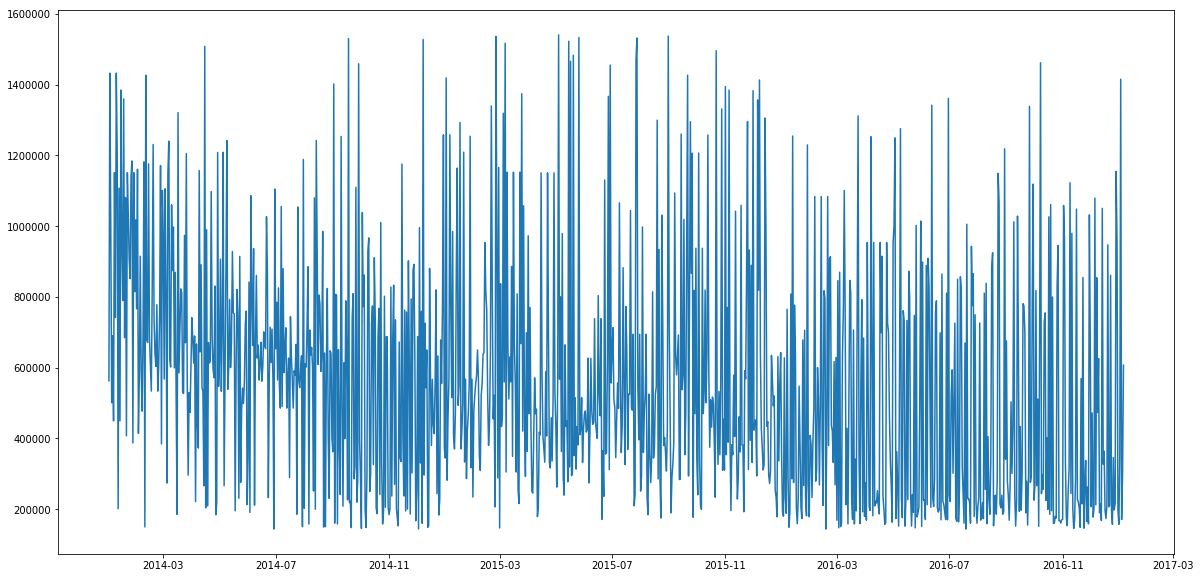

In [72]:
plt.plot(grouped.index, grouped.money)
plt.show()

In [73]:
grouped = log_money(grouped, 'money')

grouped.head()

,money,log_money
data,,
2014-01-01,562800.0,13.240680
2014-01-02,1432500.0,14.174932
2014-01-03,1000700.0,13.816210
2014-01-04,500700.0,13.123762
2014-01-05,690450.0,13.445099


In [74]:
# 计算每天的交易数
# import seaborn as sns 
daily = df.groupby(pd.TimeGrouper(freq='D'))['money'].count()
# ax = daily.plot(kind='bar')
# plt.show()

In [75]:
grouped = grouped.drop(['money'],axis = 1)
grouped.head()

,log_money
data,
2014-01-01,13.240680
2014-01-02,14.174932
2014-01-03,13.816210
2014-01-04,13.123762
2014-01-05,13.445099


In [76]:
len(daily)

1102

In [77]:
# 删除交易数为0的记录
daily_with_name = pd.DataFrame({'data':daily.index, 'count':daily.values})

daily_with_name[['count']] = daily_with_name['count'].astype(int)

unique_daily = daily_with_name[daily_with_name['count'] > 0]

unique_daily.head()

,count,data
0,4,2014-01-01
1,4,2014-01-02
2,4,2014-01-03
3,4,2014-01-04
4,4,2014-01-05


In [78]:
unique_daily.shape

(1102, 2)

In [79]:
grouped.reset_index(inplace=True)

grouped.head()

,data,log_money
0,2014-01-01,13.240680
1,2014-01-02,14.174932
2,2014-01-03,13.816210
3,2014-01-04,13.123762
4,2014-01-05,13.445099


In [80]:
# 合并两个dataframe
grouped = pd.merge(grouped, unique_daily, on="data")

grouped.head()

,data,log_money,count
0,2014-01-01,13.240680,4
1,2014-01-02,14.174932,4
2,2014-01-03,13.816210,4
3,2014-01-04,13.123762,4
4,2014-01-05,13.445099,4


In [81]:
# 把data转换为fatetime格式
grouped.set_index("data", inplace=True)
grouped.index = pd.DatetimeIndex(grouped.index)

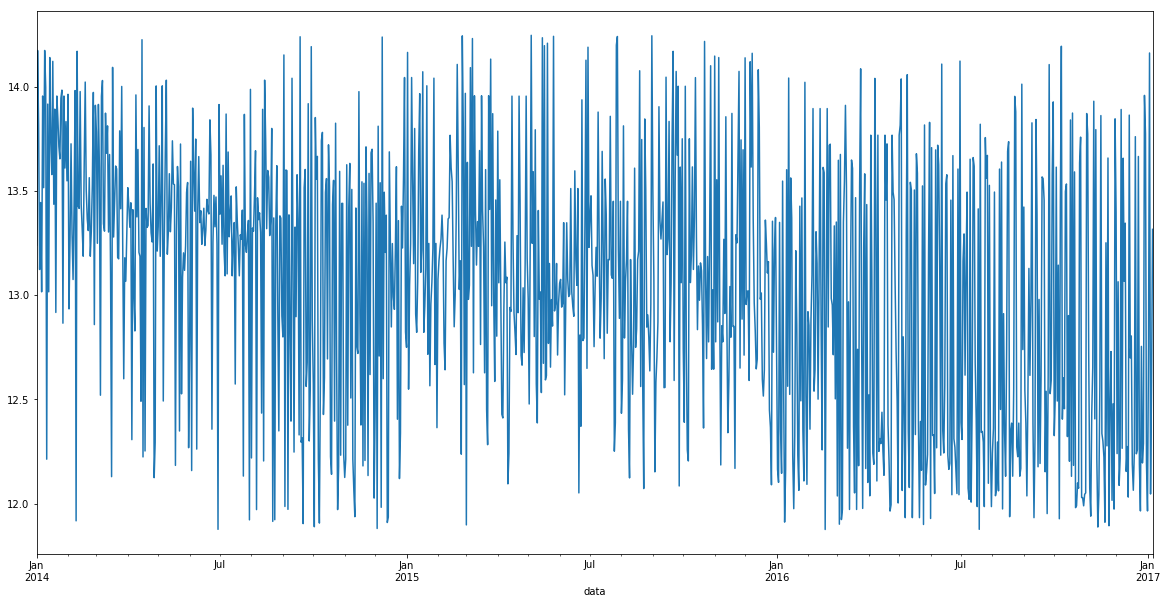

In [82]:
# 画图，观测时间序列是否平稳
grouped['log_money'][:].plot()
plt.show()

In [83]:
res = testStationarity(grouped.log_money)
res

Test Statistic                   -3.638738
p-value                           0.005062
#Lags Used                       14.000000
Number of Observations Used    1087.000000
Critical Value (5%)              -2.864203
Critical Value (1%)              -3.436380
Critical Value (10%)             -2.568188
dtype: float64

检测删除异常值

In [84]:
# # 方法一：根据平均值和标准差
# grouped.money.std(), grouped.money.mean()

# # 检测异常值
# max_money = grouped.money.mean() + 3*df.money.std()
# # 超出三倍标准差的为异常值
# outliers = grouped[np.abs(grouped.money-grouped.money.mean())>=(3*df.money.std())] 
# outliers[:10]

# # 对于异常值，使用可接受的最大值代替
# grouped['money'] = grouped['money'].map(lambda x: max_money if x > max_money else x)

In [85]:
# 方法二：根据百分比
# drop_indices = []
# percent_25 = np.percentile(grouped['money'],25)
# percent_75 = np.percentile(grouped['money'],75)
# normal_range = (percent_75 - percent_25) * 1
# outlier_indexs = grouped[(grouped['money'] < percent_25 - normal_range) | (grouped['money'] > percent_75 + normal_range)].index
# drop_indices.extend(list(outlier_indexs ))

In [86]:
# # 发现异常值
# drop_indices

In [87]:
# # 删除异常值
# grouped = grouped.drop(drop_indices)

为grouped增加其他特征

In [88]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
grouped.reset_index(inplace=True)
# 星期几
grouped['week_number'] = grouped['data'].dt.dayofweek
# 是否为工作日
grouped['weekday'] = (grouped['week_number'] // 5 == 1).astype(int)
# 是否为季度的最后一天
grouped['is_quarter_end'] = grouped['data'].dt.is_quarter_end
grouped['is_quarter_end'] = grouped['is_quarter_end'].astype(int)
# 是否为节假日
dr = grouped['data']
cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
grouped['holiday'] = grouped['data'].isin(holidays)
grouped['holiday'] = grouped['holiday'].map(lambda x: 1 if x == True else 0)

grouped.head()

,data,log_money,count,week_number,weekday,is_quarter_end,holiday
0,2014-01-01,13.240680,4,2,0,0,1
1,2014-01-02,14.174932,4,3,0,0,0
2,2014-01-03,13.816210,4,4,0,0,0
3,2014-01-04,13.123762,4,5,1,0,0
4,2014-01-05,13.445099,4,6,1,0,0


截取一部分数据做可视化分析（为了更佳的可视化效果）

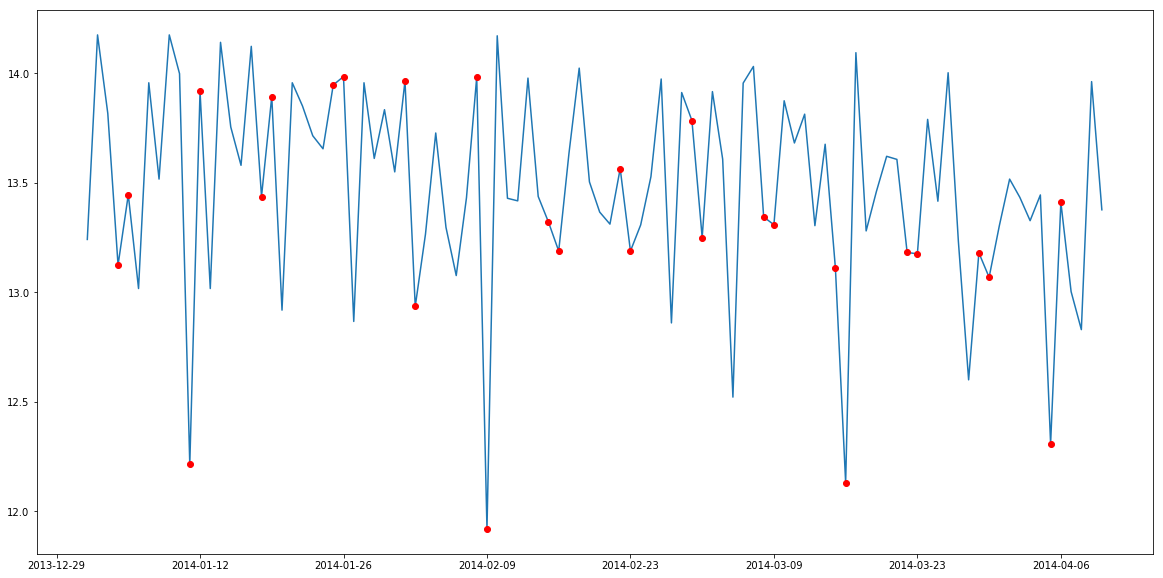

In [89]:
part_grouped = grouped[:100]
# 把index转换为datetime格式
part_grouped.set_index("data", inplace=True)
part_grouped.index = pd.DatetimeIndex(part_grouped.index)
# 观察交易量和双休是否相关
plt.plot(part_grouped.index, part_grouped.log_money)
plt.plot(part_grouped[part_grouped.weekday==1].index, part_grouped[part_grouped.weekday==1].log_money, 'ro')
plt.show()

- 双休日的交易量通常比较低  
- 通常频率为一个星期

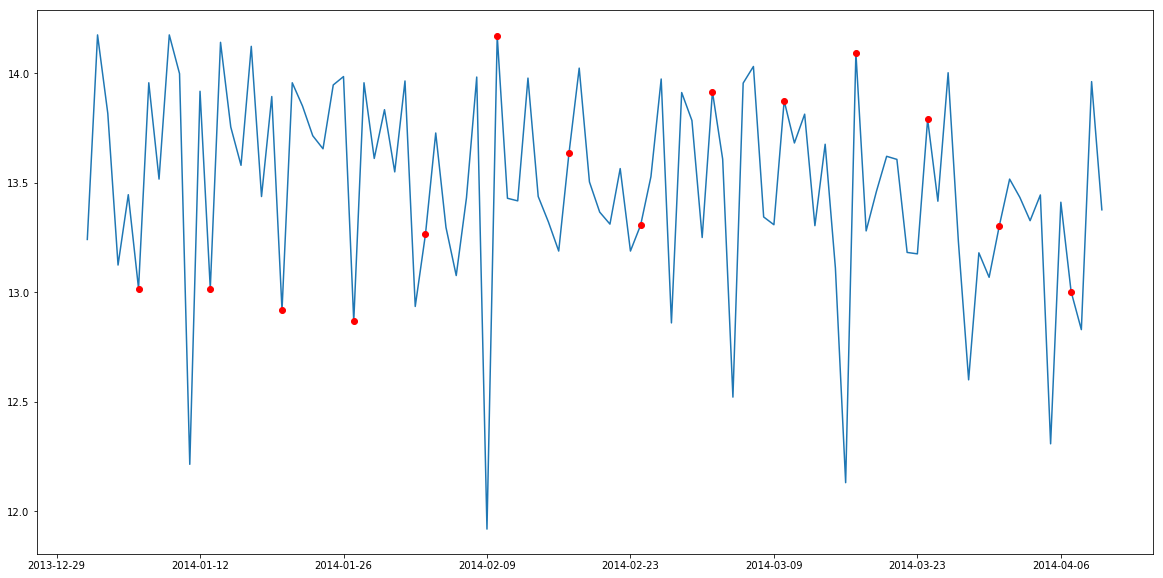

In [90]:
# 观察交易量是否在周一达到峰值
plt.plot(part_grouped.index, part_grouped.log_money)
plt.plot(part_grouped[part_grouped.week_number==0].index, part_grouped[part_grouped.week_number==0].log_money, 'ro')
plt.show()

- 通常周一的交易量比较高

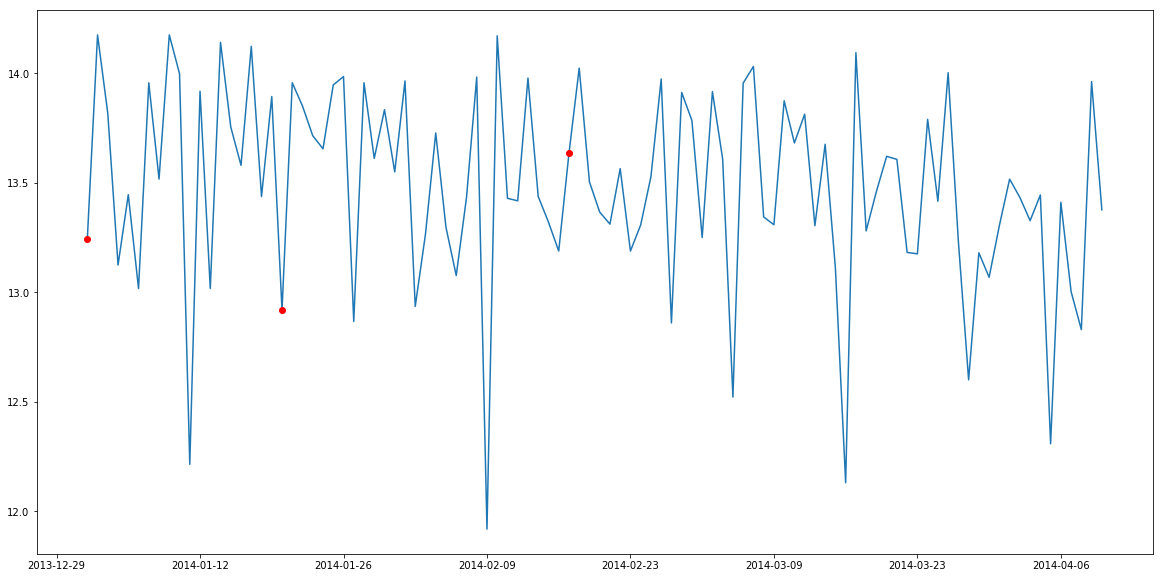

In [91]:
# 观察交易量和双休是否相关
plt.plot(part_grouped.index, part_grouped.log_money)
plt.plot(part_grouped[part_grouped.holiday==True].index, part_grouped[part_grouped.holiday==True].log_money, 'ro')
plt.show()

- 节假日的交易量没有明显特征

对数据的money特征scale并取一阶差分

In [92]:
# 把data转换为datetime格式
grouped.set_index("data", inplace=True)
grouped.index = pd.DatetimeIndex(grouped.index)

In [93]:
grouped.head()

,log_money,count,week_number,weekday,is_quarter_end,holiday
data,,,,,,
2014-01-01,13.240680,4,2,0,0,1
2014-01-02,14.174932,4,3,0,0,0
2014-01-03,13.816210,4,4,0,0,0
2014-01-04,13.123762,4,5,1,0,0
2014-01-05,13.445099,4,6,1,0,0


In [94]:
# df_money = grouped[['money']]
# # 把格式转换为numpy array，加速计算
# values = df_money.values

In [95]:
# # 把数据范围缩小到0-100
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# values = values.astype('float32')
# scaler = MinMaxScaler(feature_range = (0,100))
# scaled = scaler.fit_transform(values)

# scaled[:10]

In [96]:
# grouped['scaled_money'] = scaled

In [97]:
# grouped.head()

In [98]:
# df_money = grouped[['scaled_money']]
# df_money.to_csv('df_money.csv')

In [99]:
from __future__ import print_function
from scipy import  stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

In [100]:
# # 观察数据一阶差分后是否平稳
# data = scaled.flatten()
# dta=pd.Series(data)
# fig = plt.figure(figsize=(12,8))
# ax1= fig.add_subplot(111)
# diff1 = dta.diff(7)
# diff1.plot(ax=ax1)
# plt.show()

- 数据基本平稳

In [101]:
# # 删除原先的money特征，用一阶差分的作为新的特征代替
# scaled_list = np.asarray(diff1)
# grouped['scaled_money'] = scaled_list
# grouped = grouped.drop(['money'],axis = 1)
# grouped = grouped[7:]
# grouped.head()

In [102]:
# res = testStationarity(grouped.scaled_money)
# res

利用ARMA的思想，对时间序列的前10的每一天作为一个新特征，观察其对当天的结果的影响

In [103]:
# 把数据转换成可训练格式
def series_to_surprived(data, n_in=1, n_out=1, dropnan=True):
    # 列数
    n_vars = 1
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        # 转换成list, 前移一位
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [104]:
reframed = series_to_surprived(grouped['log_money'], 20, 1)

grouped = grouped[20:]

reframed = pd.concat([grouped,reframed], axis=1)

reframed = reframed.drop(['log_money'],axis=1)

reframed.head()

,count,week_number,weekday,is_quarter_end,holiday,var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
data,,,,,,,,,,,,,,,,,,,,,
2014-01-21,4,1,0,0,0,13.240680,14.174932,13.816210,13.123762,13.445099,...,13.917480,13.016558,14.140994,13.754114,13.579282,14.122701,13.436736,13.893443,12.917796,13.956315
2014-01-22,4,2,0,0,0,14.174932,13.816210,13.123762,13.445099,13.016558,...,13.016558,14.140994,13.754114,13.579282,14.122701,13.436736,13.893443,12.917796,13.956315,13.849960
2014-01-23,4,3,0,0,0,13.816210,13.123762,13.445099,13.016558,13.956315,...,14.140994,13.754114,13.579282,14.122701,13.436736,13.893443,12.917796,13.956315,13.849960,13.714363
2014-01-24,4,4,0,0,0,13.123762,13.445099,13.016558,13.956315,13.516430,...,13.754114,13.579282,14.122701,13.436736,13.893443,12.917796,13.956315,13.849960,13.714363,13.654755
2014-01-25,4,5,1,0,0,13.445099,13.016558,13.956315,13.516430,14.174932,...,13.579282,14.122701,13.436736,13.893443,12.917796,13.956315,13.849960,13.714363,13.654755,13.946363


In [105]:
# 把data转换为datetime格式
# reframed.set_index("data", inplace=True)
# reframed.index = pd.DatetimeIndex(reframed.index)

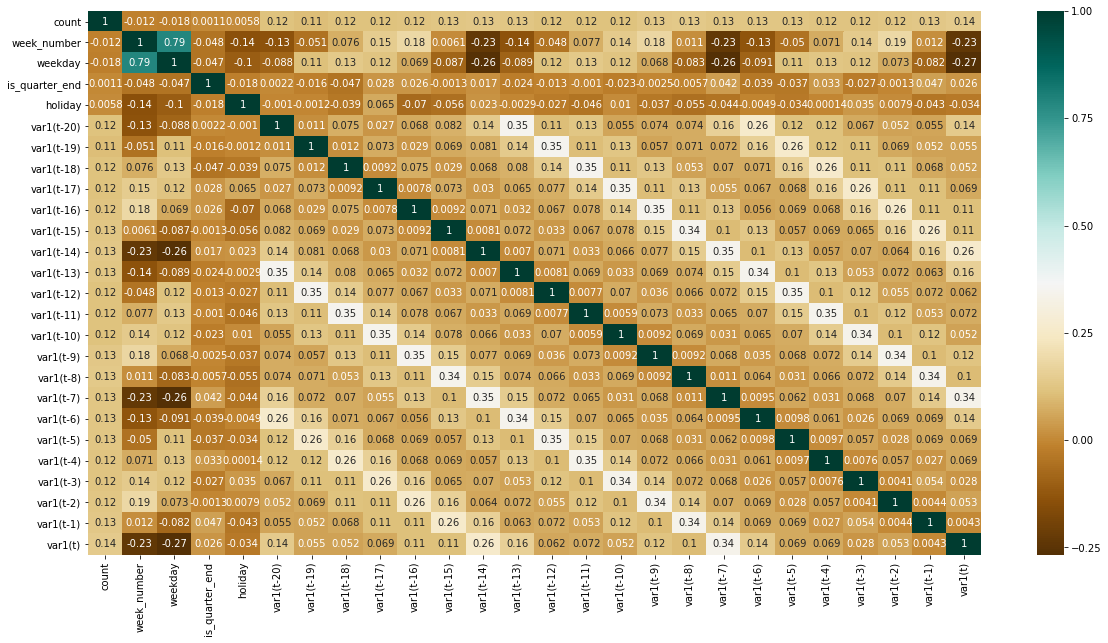

In [106]:
# 画出相关系数图
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import seaborn as sns
matrix = reframed.corr()
g= sns.heatmap(matrix,cmap = "BrBG", annot = True)
plt.show()

- var1(t)为预测值，可见、week_number, weekday, var1(t-14), var1(t-7)对当天的预测值影响较大  
- week_number和weekday有很强的联系性  
- 在后期建模过程中我们可以删掉相关性较小的特征和weekday特征  

In [107]:
# # 把reframed数据作为初步处理后的数据导出，供后期建模使用
reframed.to_csv('data/bank_after_clean_20_3512.csv')

In [108]:
reframed.head()

,count,week_number,weekday,is_quarter_end,holiday,var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
data,,,,,,,,,,,,,,,,,,,,,
2014-01-21,4,1,0,0,0,13.240680,14.174932,13.816210,13.123762,13.445099,...,13.917480,13.016558,14.140994,13.754114,13.579282,14.122701,13.436736,13.893443,12.917796,13.956315
2014-01-22,4,2,0,0,0,14.174932,13.816210,13.123762,13.445099,13.016558,...,13.016558,14.140994,13.754114,13.579282,14.122701,13.436736,13.893443,12.917796,13.956315,13.849960
2014-01-23,4,3,0,0,0,13.816210,13.123762,13.445099,13.016558,13.956315,...,14.140994,13.754114,13.579282,14.122701,13.436736,13.893443,12.917796,13.956315,13.849960,13.714363
2014-01-24,4,4,0,0,0,13.123762,13.445099,13.016558,13.956315,13.516430,...,13.754114,13.579282,14.122701,13.436736,13.893443,12.917796,13.956315,13.849960,13.714363,13.654755
2014-01-25,4,5,1,0,0,13.445099,13.016558,13.956315,13.516430,14.174932,...,13.579282,14.122701,13.436736,13.893443,12.917796,13.956315,13.849960,13.714363,13.654755,13.946363


对数据集进行异常值处理后导出，基于此数据集计算准确率

In [109]:
# 读取数据的同时把data转换为datetime格式并设为Index
df = pd.read_csv('data/3512zizhufk.csv', parse_dates = True, 
                 index_col=0)

df.head()

,money
data,
2014-01-01,69800.0
2014-01-02,113900.0
2014-01-03,250900.0
2014-01-04,74700.0
2014-01-05,111200.0


In [110]:
# 对同一天的数据累加
grouped = df.groupby(level=0).sum()
grouped.head()

,money
data,
2014-01-01,562800.0
2014-01-02,1560400.0
2014-01-03,1000700.0
2014-01-04,500700.0
2014-01-05,690450.0


In [111]:
# 把前后10%定义为异常值，把异常值用对应前后一个星期的那一天的平均值替换
ts = Custompercentilenan(grouped.money,10,90,1)

In [112]:
grouped = pd.DataFrame({'money':ts.values},index=ts.index)

In [113]:
grouped.head()

,money
data,
2014-01-01,562800.0
2014-01-02,1432500.0
2014-01-03,1000700.0
2014-01-04,500700.0
2014-01-05,690450.0


In [114]:
grouped.to_csv('data/original_log_no_abnorm_3512.csv')